In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

**Note:** This notebook can run using TensorFlow 2.5.0

In [ ]:
#!pip install tensorflow==2.5.0

In [1]:
import tensorflow as tf
print(tf.__version__)

# !pip install -q tensorflow-datasets

import tensorflow_datasets as tfds
imdb, info = tfds.load("imdb_reviews", with_info=True, as_supervised=True)


2.8.0


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKQ6COD/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKQ6COD/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKQ6COD/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [2]:
import numpy as np

train_data, test_data = imdb['train'], imdb['test']

training_sentences = []
training_labels = []

testing_sentences = []
testing_labels = []

# str(s.tonumpy()) is needed in Python3 instead of just s.numpy()
for s,l in train_data:
  training_sentences.append(str(s.numpy()))
  training_labels.append(l.numpy())
  
for s,l in test_data:
  testing_sentences.append(str(s.numpy()))
  testing_labels.append(l.numpy())
  
training_labels_final = np.array(training_labels)
testing_labels_final = np.array(testing_labels)


In [25]:
vocab_size = 10000
embedding_dim = 16
max_length = 120
trunc_type='post'
oov_tok = "<OOV>"


from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)


In [4]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print(decode_review(padded[1]))
print(training_sentences[1])

? ? ? ? ? ? ? b'i have been known to fall asleep during films but this is usually due to a combination of things including really tired being warm and comfortable on the <OOV> and having just eaten a lot however on this occasion i fell asleep because the film was rubbish the plot development was constant constantly slow and boring things seemed to happen but with no explanation of what was causing them or why i admit i may have missed part of the film but i watched the majority of it and everything just seemed to happen of its own <OOV> without any real concern for anything else i cant recommend this film at all '
b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell asleep because the film was rubbish. The plot development was constant. Constantly slow and boring. Things seemed to happen, but with no explanation of 

In [5]:
from tensorflow import keras
early_stopping = keras.callbacks.EarlyStopping(patience=8, monitor='val_loss')
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_lr=1e-6,
patience=3, mode='min',
verbose=0)
model_checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss',
filepath='./best_model.h5',
save_best_only=True)
callbacks = [early_stopping,  model_checkpoint,reduce_lr]

In [6]:
model_1gru = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')],name = "model_1gru".upper())
model_1gru.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-2),metrics=['accuracy'])

model_1gru.summary()


Model: "MODEL_1GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 16)           160000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9600      
 l)                                                              
                                                                 
 dense (Dense)               (None, 60)                3900      
                                                                 
 dropout (Dropout)           (None, 60)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 61        
                                                                 
Total params: 173,561
Trainable params: 173,561
Non-trainable params: 0
__________________________________________________

In [7]:
import matplotlib.pyplot as plt


def plot_graphs(history, string,model):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.title(model.name)
  plt.show()



In [8]:
# Model Definition with LSTM
model_1lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')],name ="model_1lstm".upper())
model_1lstm.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-2),metrics=['accuracy'])
model_1lstm.summary()


Model: "MODEL_1LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               12544     
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 60)                3900      
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 61        
                                                                 
Total params: 176,505
Trainable params: 176,505
Non-trainable params: 0
_________________________________________________

In [9]:
# Model Definition with Conv1D
model_conv1D = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(60, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
],name ="model_conv1D".upper())
model_conv1D.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-2),metrics=['accuracy'])
model_conv1D.summary()


Model: "MODEL_CONV1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d (Conv1D)             (None, 116, 128)          10368     
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_4 (Dense)             (None, 60)                7740      
                                                                 
 dropout_2 (Dropout)         (None, 60)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 61        
                                                      

In [10]:
#model mixto
# Model Definition with Conv1D
model_gru_lstm_conv = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Conv1D(128, 5, activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,return_sequences = True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),    
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
],name ="model_gru_lstm_conv".upper())
model_gru_lstm_conv.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.Adam(learning_rate= 1e-2),metrics=['accuracy'])

model_gru_lstm_conv.summary()


Model: "MODEL_GRU_LSTM_CONV"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 120, 16)           160000    
                                                                 
 conv1d_1 (Conv1D)           (None, 116, 128)          10368     
                                                                 
 bidirectional_2 (Bidirectio  (None, 116, 64)          41216     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               18816     
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dropout_3 (Dropout)         (None, 64)        

In [11]:
#model dense simple

model_dense_simple = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64,activation= "relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
],name ="dense_simple".upper())
model_dense_simple.compile(loss='binary_crossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-2),metrics=['accuracy'])
model_dense_simple.summary()


Model: "DENSE_SIMPLE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 120, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_8 (Dense)             (None, 64)                1088      
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 65        
                                                                 
Total params: 161,153
Trainable params: 161,153
Non-trainable params: 0
________________________________________________

In [13]:
model_bi_GRU= tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
],name = "model_bi_GRU".upper() )
model_bi_GRU.summary()

Model: "MODEL_BI_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 120, 16)           160000    
                                                                 
 bidirectional_4 (Bidirectio  (None, 120, 128)         31488     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               31104     
 nal)                                                            
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 1)                 65        
                                                                 
Total params: 226,817
Trainable params: 226,817
Non-tr

In [23]:
import numpy as np
embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=160000
tokenizer = Tokenizer(num_words = training_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences,maxlen=max_length)
##########################
embeddings_index = {};

with open('./glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;
embedding_dim = 100
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector
model_glove = tf.keras.Sequential([
    # YOUR CODE HERE
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=4),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
],name = "model_glove".upper() )
model_glove.summary()

Model: "MODEL_GLOVE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 16, 100)           16000100  
                                                                 
 dropout_5 (Dropout)         (None, 16, 100)           0         
                                                                 
 conv1d_2 (Conv1D)           (None, 12, 64)            32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 3, 64)            0         
 )                                                               
                                                                 
 lstm_2 (LSTM)               (None, 64)                33024     
                                                                 
 dense_12 (Dense)            (None, 1)                 65        
                                                       

MODEL_GRU_LSTM_CONV
##############################
El modelo MODEL_GRU_LSTM_CONV resultó en 86.0 % de acierto. 


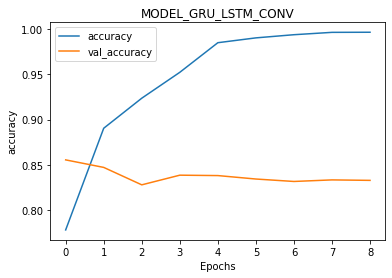

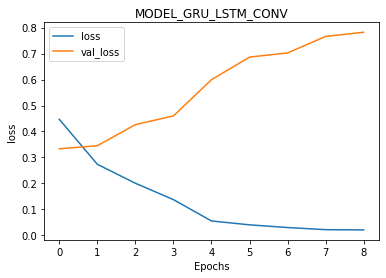

Este modelo: MODEL_GRU_LSTM_CONV, demoró 3.89 minutos en ejecutarse.

&#=&#=&#=&#=&#=&#=&#=&#=&#=&#=
MODEL_CONV1D
##############################
El modelo MODEL_CONV1D resultó en 85.0 % de acierto. 


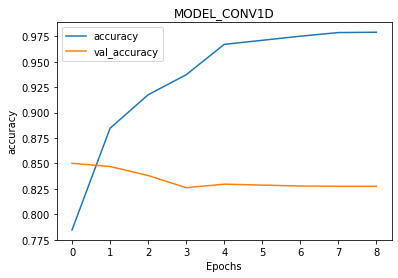

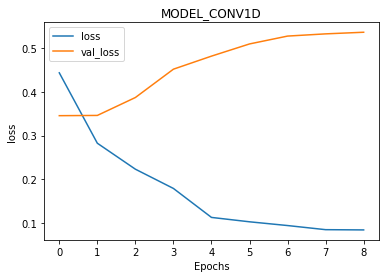

Este modelo: MODEL_CONV1D, demoró 0.93 minutos en ejecutarse.

&#=&#=&#=&#=&#=&#=&#=&#=&#=&#=
MODEL_1LSTM
##############################
El modelo MODEL_1LSTM resultó en 85.0 % de acierto. 


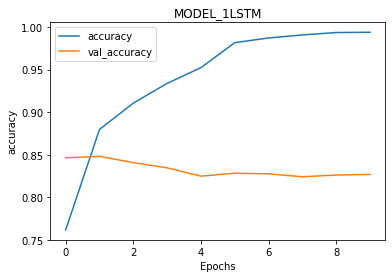

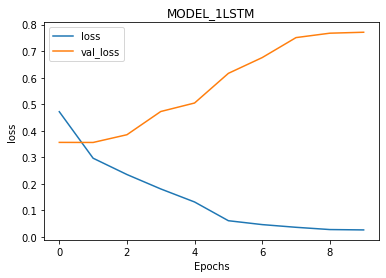

Este modelo: MODEL_1LSTM, demoró 2.54 minutos en ejecutarse.

&#=&#=&#=&#=&#=&#=&#=&#=&#=&#=
MODEL_1GRU
##############################
El modelo MODEL_1GRU resultó en 84.0 % de acierto. 


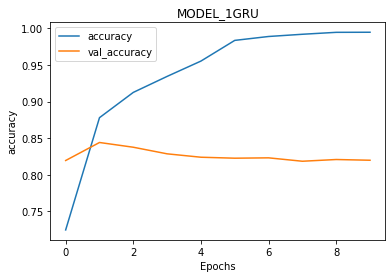

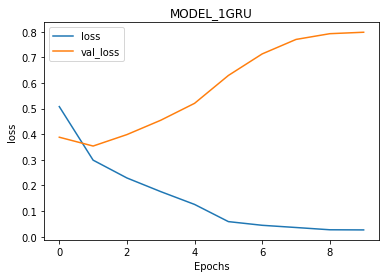

Este modelo: MODEL_1GRU, demoró 2.53 minutos en ejecutarse.

&#=&#=&#=&#=&#=&#=&#=&#=&#=&#=
DENSE_SIMPLE
##############################
El modelo DENSE_SIMPLE resultó en 85.0 % de acierto. 


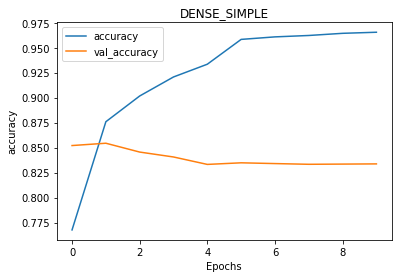

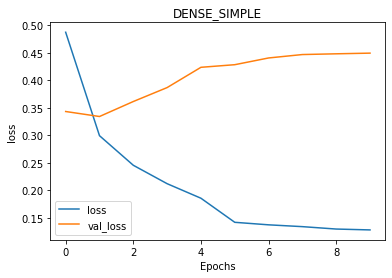

Este modelo: DENSE_SIMPLE, demoró 1.41 minutos en ejecutarse.

&#=&#=&#=&#=&#=&#=&#=&#=&#=&#=
MODEL_BI_GRU
##############################
El modelo MODEL_BI_GRU resultó en 83.0 % de acierto. 


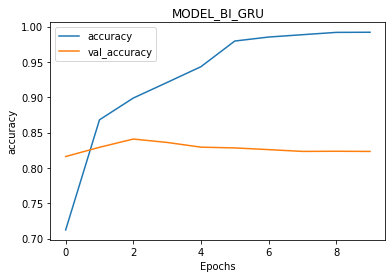

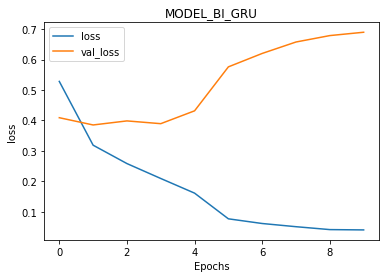

Este modelo: MODEL_BI_GRU, demoró 4.63 minutos en ejecutarse.

&#=&#=&#=&#=&#=&#=&#=&#=&#=&#=
MODEL_GLOVE
##############################
El modelo MODEL_GLOVE resultó en 65.0 % de acierto. 


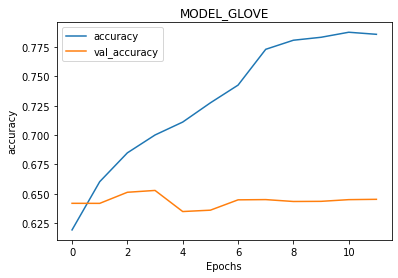

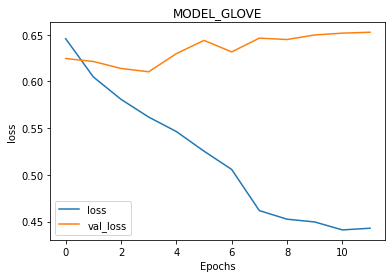

Este modelo: MODEL_GLOVE, demoró 1.65 minutos en ejecutarse.

&#=&#=&#=&#=&#=&#=&#=&#=&#=&#=
Para MODEL_GRU_LSTM_CONV se obtuvo una accuracy de 0.856.
Para MODEL_CONV1D se obtuvo una accuracy de 0.85.
Para MODEL_1LSTM se obtuvo una accuracy de 0.848.
Para MODEL_1GRU se obtuvo una accuracy de 0.844.
Para DENSE_SIMPLE se obtuvo una accuracy de 0.854.
Para MODEL_BI_GRU se obtuvo una accuracy de 0.829.
Para MODEL_GLOVE se obtuvo una accuracy de 0.653.


<Figure size 432x288 with 0 Axes>

In [26]:

import os
for file in os.listdir():
             if file.endswith("keras"):
                  os.remove(file)
             elif file.endswith("txt"):
                  os.remove(file)
             elif file.endswith("png"):
                  os.remove(file)
import time
resultados ={}
num_epochs = 150
modelos = [model_gru_lstm_conv,model_conv1D,model_1lstm,model_1gru,model_dense_simple,model_bi_GRU,model_glove]
for model in modelos:
        now = time.time()  

        print (model.name)
        model.compile(loss='binary_crossentropy',optimizer = tf.keras.optimizers.Adam(learning_rate= 1e-3),metrics=['accuracy'])
        print ("#"*30 )
        model_checkpoint = keras.callbacks.ModelCheckpoint(monitor='val_loss', filepath= model.name+".keras", save_best_only=True)
        callbacks = [early_stopping,  model_checkpoint,reduce_lr]
        if model == model_glove:
              import numpy as np
              embedding_dim = 100
              max_length = 16
              trunc_type='post'
              padding_type='post'
              oov_tok = "<OOV>"
              training_size=160000
              tokenizer = Tokenizer(num_words = training_size, oov_token=oov_tok)
              tokenizer.fit_on_texts(training_sentences)
              word_index = tokenizer.word_index
              sequences = tokenizer.texts_to_sequences(training_sentences)
              padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)

              testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
              testing_padded = pad_sequences(testing_sequences,maxlen=max_length)
        history = model.fit(padded, training_labels_final, epochs=num_epochs, validation_data=(testing_padded, testing_labels_final),
                            callbacks = [callbacks], verbose=0)
        model = model = tf.keras.models.load_model(model.name+".keras")
        loss, accuracy = model.evaluate(testing_padded,testing_labels_final,verbose=0)
        resultados[model.name]=accuracy

        print (f"El modelo {model.name} resultó en {round(accuracy,2)*100} % de acierto. ")
        with open('Comparación neural networks text classifiation.txt', 'a') as f:
                f.write(f"El modelo {model.name} resultó en {round(accuracy,2)*100} % de acierto.\n ")
        plot_graphs(history, 'accuracy',model)
        plt.savefig(model.name+"_accuracy.")    
        plot_graphs(history, 'loss',model) 
        plt.savefig(model.name+"_loss.") 
        print (f"Este modelo: {model.name}, demoró {round((time.time()-now)/60,2)} minutos en ejecutarse.\n")
        with open('Comparación neural networks text classification.txt', 'a') as f:
                f.write(f"Este modelo: {model.name}, demoró {round((time.time()-now)/60,2)} minutos en ejecutarse.\n")
        print ("&#="*10)

for key,value in resultados.items():
      print (f"Para {key} se obtuvo una accuracy de {round(value,3)}.");

In [34]:
import pandas as pd
resultados_pd= pd.DataFrame.from_dict(resultados,orient='index',columns=["Accuracy"])

In [38]:
resultados_pd=resultados_pd.reset_index()

In [40]:
resultados_pd.columns =["Modelos","Accuracy"]


In [41]:
resultados_pd

,Modelos,Accuracy
0,MODEL_GRU_LSTM_CONV,0.85560
1,MODEL_CONV1D,0.85016
2,MODEL_1LSTM,0.84812
3,MODEL_1GRU,0.84412
4,DENSE_SIMPLE,0.85436
5,MODEL_BI_GRU,0.82920
6,MODEL_GLOVE,0.65292
